In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the dataset
print("Loading dataset...")
df = pd.read_excel('SLU Opportunity Wise Data-1710158595043.xlsx', sheet_name='Original')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

Loading dataset...
Dataset Shape: (8558, 16)

Columns: ['Learner SignUp DateTime', 'Opportunity Id', 'Opportunity Name', 'Opportunity Category', 'Opportunity End Date', 'First Name', 'Date of Birth', 'Gender', 'Country', 'Institution Name', 'Current/Intended Major', 'Entry created at', 'Status Description', 'Status Code', 'Apply Date', 'Opportunity Start Date']

First few rows:
  Learner SignUp DateTime                  Opportunity Id  \
0     06/14/2023 12:30:35  00000000-0GN2-A0AY-7XK8-C5FZPP   
1     2023-01-05 05:29:16  00000000-0GN2-A0AY-7XK8-C5FZPP   
2     2023-09-04 20:35:08  00000000-0GN2-A0AY-7XK8-C5FZPP   
3     08/29/2023 05:20:03  00000000-0GN2-A0AY-7XK8-C5FZPP   
4     2023-06-01 15:26:36  00000000-0GN2-A0AY-7XK8-C5FZPP   

                                    Opportunity Name Opportunity Category  \
0  Career Essentials: Getting Started with Your P...               Course   
1  Career Essentials: Getting Started with Your P...               Course   
2  Career Essentials:

In [18]:
# DATA PREPARATION & CHURN DEFINITION
print("\nPreparing data...")

# Define churn based on Status Description
churn_mapping = {
    'Withdraw': 1,
    'Waitlisted': 1,  # Can be considered as potential churn
    'Started': 0,
    'Team Allocated': 0,
    'Rewards Award': 0
}

df['Churn'] = df['Status Description'].map(churn_mapping)

# Handle any unmapped statuses
if df['Churn'].isnull().any():
    df['Churn'].fillna(0, inplace=True)  # Default to not churn

print(f"\nChurn Distribution:\n{df['Churn'].value_counts()}")
print(f"Churn Rate: {(df['Churn'].sum()/len(df)*100):.2f}%")

# DATA CLEANING & FEATURE ENGINEERING
print("\nCleaning data and engineering features...")

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

# Handle date columns
date_columns = ['Learner_SignUp_DateTime', 'Opportunity_End_Date', 
                'Date_of_Birth', 'Entry_created_at', 'Apply_Date', 
                'Opportunity_Start_Date']

for col in date_columns:
    if col in df.columns:
        try:
            # Handle mixed date formats
            df[col] = pd.to_datetime(df[col], errors='coerce')
        except:
            # Try different format if needed
            try:
                df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %H:%M:%S', errors='coerce')
            except:
                df[col] = pd.NaT

# Create time-based features
if 'Learner_SignUp_DateTime' in df.columns and 'Apply_Date' in df.columns:
    df['Signup_to_Apply_Days'] = (df['Apply_Date'] - df['Learner_SignUp_DateTime']).dt.days
    df['Signup_Month'] = df['Learner_SignUp_DateTime'].dt.month
    df['Signup_Weekday'] = df['Learner_SignUp_DateTime'].dt.weekday

# Age calculation
if 'Date_of_Birth' in df.columns:
    # Use the latest date in the dataset or current date as reference
    reference_date = df['Date_of_Birth'].max() if not df['Date_of_Birth'].isnull().all() else pd.Timestamp('2024-01-01')
    df['Age'] = (reference_date - df['Date_of_Birth']).dt.days / 365.25
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 25, 35, 50, 100], 
                            labels=['<18', '18-25', '26-35', '36-50', '50+'])

# Duration features
if 'Opportunity_Start_Date' in df.columns and 'Opportunity_End_Date' in df.columns:
    df['Course_Duration_Days'] = (df['Opportunity_End_Date'] - df['Opportunity_Start_Date']).dt.days

# Handle missing values in key columns
for col in ['First_Name', 'Current_Intended_Major', 'Institution_Name', 'Country']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Create a unique user identifier
df['User_ID'] = df['First_Name'].astype(str) + '_' + df['Date_of_Birth'].astype(str)

print(f"\nData preparation complete!")
print(f"Total users: {df['User_ID'].nunique()}")
print(f"Total opportunities: {df['Opportunity_Id'].nunique()}")



Preparing data...

Churn Distribution:
Churn
0.0    8363
1.0     195
Name: count, dtype: int64
Churn Rate: 2.28%

Cleaning data and engineering features...

Data preparation complete!
Total users: 3850
Total opportunities: 23


In [22]:
# RECOMMENDATION SYSTEM IMPLEMENTATION

print("\n" + "="*50)
print("BUILDING RECOMMENDATION SYSTEM")
print("="*50)

def prepare_recommendation_features(df):
    """
    Prepare features for collaborative and content-based filtering
    """
    
    # Create user features
    print("Preparing user features...")
    
    # User demographic features
    user_profile = df.groupby('User_ID').agg({
        'Age': 'first',
        'Gender': 'first',
        'Country': 'first',
        'Institution_Name': 'first',
        'Current_Intended_Major': 'first',
        'Age_Group': 'first'
    }).reset_index()
    
    # User behavior features
    user_behavior = df.groupby('User_ID').agg({
        'Opportunity_Id': 'count',  # Total opportunities applied to
        'Churn': 'mean',  # Churn rate
        'Signup_to_Apply_Days': 'mean',  # Average time to apply
        'Status_Description': lambda x: (x == 'Started').sum()  # Count of started opportunities
    }).rename(columns={
        'Opportunity_Id': 'Total_Applications',
        'Status_Description': 'Started_Count'
    }).reset_index()
    
    # Merge user features
    user_features = pd.merge(user_profile, user_behavior, on='User_ID', how='left')
    
    # Create opportunity features
    print("Preparing opportunity features...")
    
    opportunity_features = df.groupby('Opportunity_Id').agg({
        'Opportunity_Name': 'first',
        'Opportunity_Category': 'first',
        'Course_Duration_Days': 'first',
        'Churn': 'mean',  # Opportunity churn rate
        'Age': 'mean',  # Average age of applicants
        'Gender': lambda x: (x == 'Female').mean(),  # Gender distribution
        'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',  # Most common country
        'Current_Intended_Major': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'  # Most common major
    }).reset_index()
    
    opportunity_features = opportunity_features.rename(columns={
        'Churn': 'Opportunity_Churn_Rate',
        'Age': 'Avg_Applicant_Age',
        'Gender': 'Female_Ratio'
    })
    
    # Create user-opportunity interaction matrix
    print("Creating interaction matrix...")
    
    # Create engagement scores based on status
    engagement_scores = {
        'Withdraw': 0,
        'Waitlisted': 1,
        'Started': 3,
        'Team Allocated': 4,
        'Rewards Award': 5
    }
    
    df['Engagement_Score'] = df['Status_Description'].map(engagement_scores)
    
    # Create interaction matrix
    interaction_matrix = df.pivot_table(
        index='User_ID',
        columns='Opportunity_Id',
        values='Engagement_Score',
        fill_value=0
    )
    
    return user_features, opportunity_features, interaction_matrix

# Prepare features
user_features, opportunity_features, interaction_matrix = prepare_recommendation_features(df)

print(f"User features shape: {user_features.shape}")
print(f"Opportunity features shape: {opportunity_features.shape}")
print(f"Interaction matrix shape: {interaction_matrix.shape}")

# 1. CONTENT-BASED FILTERING
print("\n" + "-"*50)
print("CONTENT-BASED FILTERING")
print("-"*50)

def content_based_recommendations(user_id, opportunity_features, user_features, top_n=5):
    """
    Content-based filtering based on user profile and opportunity features
    """
    
    # Get user profile
    user_profile = user_features[user_features['User_ID'] == user_id]
    
    if user_profile.empty:
        print(f"User {user_id} not found!")
        return None
    
    # Prepare text features for TF-IDF
    opportunity_text_features = opportunity_features['Opportunity_Name'].fillna('') + ' ' + \
                                opportunity_features['Opportunity_Category'].fillna('') + ' ' + \
                                opportunity_features['Current_Intended_Major'].fillna('')
    
    # Create TF-IDF matrix for opportunities
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(opportunity_text_features)
    
    # Prepare user text profile
    user_text_profile = ""
    if pd.notna(user_profile['Current_Intended_Major'].values[0]):
        user_text_profile += str(user_profile['Current_Intended_Major'].values[0]) + ' '
    if pd.notna(user_profile['Institution_Name'].values[0]):
        user_text_profile += str(user_profile['Institution_Name'].values[0])
    
    # Transform user profile to TF-IDF space
    user_tfidf = tfidf.transform([user_text_profile])
    
    # Calculate cosine similarity
    cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix).flatten()
    
    # Get top N similar opportunities
    similar_indices = cosine_sim.argsort()[-top_n:][::-1]
    
    # Prepare recommendations
    recommendations = []
    for idx in similar_indices:
        opp_id = opportunity_features.iloc[idx]['Opportunity_Id']
        opp_name = opportunity_features.iloc[idx]['Opportunity_Name']
        similarity_score = cosine_sim[idx]
        
        recommendations.append({
            'Opportunity_ID': opp_id,
            'Opportunity_Name': opp_name,
            'Similarity_Score': similarity_score,
            'Category': opportunity_features.iloc[idx]['Opportunity_Category'],
            'Churn_Rate': opportunity_features.iloc[idx]['Opportunity_Churn_Rate']
        })
    
    return pd.DataFrame(recommendations)

# Test content-based recommendations
if len(user_features) > 0:
    sample_user = user_features.iloc[0]['User_ID']
    print(f"\nContent-based recommendations for user: {sample_user}")
    content_recs = content_based_recommendations(sample_user, opportunity_features, user_features, top_n=5)
    if content_recs is not None:
        print(content_recs[['Opportunity_Name', 'Similarity_Score', 'Category', 'Churn_Rate']])
else:
    print("No user features available for content-based filtering")



BUILDING RECOMMENDATION SYSTEM
Preparing user features...
Preparing opportunity features...
Creating interaction matrix...
User features shape: (3850, 11)
Opportunity features shape: (23, 9)
Interaction matrix shape: (2637, 21)

--------------------------------------------------
CONTENT-BASED FILTERING
--------------------------------------------------

Content-based recommendations for user: 11_2003-09-25
                                    Opportunity_Name  Similarity_Score  \
0                  Upload Your First Year Transcript               0.0   
1                 Mental and Physical Health Session               0.0   
2     Slide Geeks: A Presentation Design Competition               0.0   
3  Career Essentials: Getting Started with Your P...               0.0   
4                                  Digital Marketing               0.0   

      Category  Churn_Rate  
0   Engagement    0.000000  
1        Event    0.000000  
2  Competition    0.000000  
3       Course    0.056219  

In [24]:
# 2. POPULARITY-BASED RECOMMENDATIONS
print("\n" + "-"*50)
print("POPULARITY-BASED RECOMMENDATIONS")
print("-"*50)

def popularity_based_recommendations(df, opportunity_features, top_n=10, min_applications=3):
    """
    Recommend popular opportunities with low churn rates
    """
    
    # Calculate popularity metrics
    popularity_stats = df.groupby('Opportunity_Id').agg({
        'User_ID': 'count',  # Number of applicants
        'Churn': 'mean',  # Churn rate
    }).rename(columns={
        'User_ID': 'Applicant_Count',
        'Churn': 'Churn_Rate',
    }).reset_index()
    
    # Filter opportunities
    filtered_opps = popularity_stats[
        (popularity_stats['Applicant_Count'] >= min_applications)
    ].copy()
    
    # Calculate popularity score
    if len(filtered_opps) > 0:
        filtered_opps['Popularity_Score'] = (
            0.7 * (filtered_opps['Applicant_Count'] / filtered_opps['Applicant_Count'].max()) +
            0.3 * (1 - filtered_opps['Churn_Rate'])
        )
    
        # Get top N popular opportunities
        popular_opps = filtered_opps.sort_values('Popularity_Score', ascending=False).head(top_n)
        
        # Merge with opportunity details
        recommendations = pd.merge(
            popular_opps,
            opportunity_features[['Opportunity_Id', 'Opportunity_Name', 'Opportunity_Category']],
            on='Opportunity_Id',
            how='left'
        )
        
        return recommendations[['Opportunity_Name', 'Opportunity_Category', 
                               'Applicant_Count', 'Churn_Rate', 'Popularity_Score']]
    else:
        print("Not enough data for popularity-based recommendations")
        return pd.DataFrame()

# Get popular recommendations
print("\nMost popular opportunities:")
popular_recs = popularity_based_recommendations(df, opportunity_features, top_n=10)
if not popular_recs.empty:
    print(popular_recs)
else:
    print("Using all opportunities for recommendations")
    # Fallback: just show top opportunities by name
    top_opportunities = opportunity_features.sort_values('Opportunity_Churn_Rate').head(10)
    print(top_opportunities[['Opportunity_Name', 'Opportunity_Category', 'Opportunity_Churn_Rate']])


--------------------------------------------------
POPULARITY-BASED RECOMMENDATIONS
--------------------------------------------------

Most popular opportunities:
                                    Opportunity_Name Opportunity_Category  \
0  Career Essentials: Getting Started with Your P...               Course   
1                                 Data Visualization           Internship   
2                                 Project Management           Internship   
3                             Health Care Management           Internship   
4                                  Digital Marketing           Internship   
5                       Data Visualization Associate           Internship   
6                                Business Consulting           Internship   
7                       Project Management Associate           Internship   
8                      Innovation & Entrepreneurship           Internship   
9                Digital Strategy Virtual Internship           In

In [26]:
# 3. SIMILARITY-BASED RECOMMENDATIONS
print("\n" + "-"*50)
print("SIMILARITY-BASED RECOMMENDATIONS")
print("-"*50)

def get_similar_opportunities(opportunity_id, opportunity_features, top_n=5):
    """
    Find opportunities similar to a given opportunity
    """
    
    # Find the opportunity
    target_opp = opportunity_features[opportunity_features['Opportunity_Id'] == opportunity_id]
    
    if target_opp.empty:
        print(f"Opportunity {opportunity_id} not found!")
        return None
    
    # Prepare text features
    opportunity_text_features = opportunity_features['Opportunity_Name'].fillna('') + ' ' + \
                                opportunity_features['Opportunity_Category'].fillna('') + ' ' + \
                                opportunity_features['Current_Intended_Major'].fillna('')
    
    # Create TF-IDF matrix
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(opportunity_text_features)
    
    # Get index of target opportunity
    target_idx = opportunity_features[opportunity_features['Opportunity_Id'] == opportunity_id].index[0]
    
    # Calculate similarity with all opportunities
    cosine_sim = cosine_similarity(tfidf_matrix[target_idx:target_idx+1], tfidf_matrix).flatten()
    
    # Get top N similar opportunities (excluding the target itself)
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]
    
    # Prepare recommendations
    recommendations = []
    for idx in similar_indices:
        opp_id = opportunity_features.iloc[idx]['Opportunity_Id']
        opp_name = opportunity_features.iloc[idx]['Opportunity_Name']
        similarity_score = cosine_sim[idx]
        
        recommendations.append({
            'Opportunity_ID': opp_id,
            'Opportunity_Name': opp_name,
            'Similarity_Score': similarity_score,
            'Category': opportunity_features.iloc[idx]['Opportunity_Category'],
            'Churn_Rate': opportunity_features.iloc[idx]['Opportunity_Churn_Rate']
        })
    
    return pd.DataFrame(recommendations)

# Test similarity-based recommendations
if len(opportunity_features) > 0:
    sample_opportunity = opportunity_features.iloc[0]['Opportunity_Id']
    print(f"\nOpportunities similar to: {opportunity_features.iloc[0]['Opportunity_Name']}")
    similar_recs = get_similar_opportunities(sample_opportunity, opportunity_features, top_n=5)
    if similar_recs is not None:
        print(similar_recs[['Opportunity_Name', 'Similarity_Score', 'Category', 'Churn_Rate']])



--------------------------------------------------
SIMILARITY-BASED RECOMMENDATIONS
--------------------------------------------------

Opportunities similar to: Project Management
                      Opportunity_Name  Similarity_Score    Category  \
0         Project Management Associate          0.836892  Internship   
1               Health Care Management          0.459939  Internship   
2  Digital Strategy Virtual Internship          0.287310  Internship   
3                   Data Visualization          0.258299  Internship   
4                  Business Consulting          0.245583  Internship   

   Churn_Rate  
0    0.002092  
1    0.025510  
2    0.012085  
3    0.010204  
4    0.008282  


In [30]:
# 4. USER PERSONALIZATION ENGINE
print("\n" + "-"*50)
print("USER PERSONALIZATION ENGINE")
print("-"*50)

def generate_personalized_recommendations(user_id, df, user_features, opportunity_features, 
                                        interaction_matrix=None, top_n=10):
    """
    Generate personalized recommendations for a user
    """
    
    print(f"\nGenerating recommendations for user: {user_id}")
    
    # Get user information
    user_info = user_features[user_features['User_ID'] == user_id]
    
    if user_info.empty:
        print("User not found. Returning popular recommendations.")
        return popularity_based_recommendations(df, opportunity_features, top_n=top_n)
    
    # Get user's application history
    user_history = df[df['User_ID'] == user_id]
    
    if len(user_history) == 0:
        print("New user with no history. Returning popular recommendations.")
        return popularity_based_recommendations(df, opportunity_features, top_n=top_n)
    
    # Get content-based recommendations
    print("Generating content-based recommendations...")
    content_recs = content_based_recommendations(user_id, opportunity_features, user_features, top_n=top_n*2)
    
    # Get opportunities user has already applied to
    applied_opportunities = set(user_history['Opportunity_Id'].unique())
    
    # Filter out already applied opportunities
    if content_recs is not None and not content_recs.empty:
        content_recs = content_recs[~content_recs['Opportunity_ID'].isin(applied_opportunities)]
    
    # Get user's preferred category
    if len(user_history) > 0:
        preferred_category = user_history['Opportunity_Category'].mode()
        if len(preferred_category) > 0:
            preferred_category = preferred_category[0]
        else:
            preferred_category = None
    else:
        preferred_category = None
    
    # Generate recommendations based on user profile
    recommendations_list = []
    
    # 1. Content-based recommendations
    if content_recs is not None and not content_recs.empty:
        for _, row in content_recs.iterrows():
            score = row['Similarity_Score'] * (1 - row['Churn_Rate'])
            recommendations_list.append({
                'Opportunity_ID': row['Opportunity_ID'],
                'Opportunity_Name': row['Opportunity_Name'],
                'Score': score,
                'Type': 'Content-Based',
                'Category': row['Category'],
                'Churn_Rate': row['Churn_Rate'],
                'Success_Probability': 1 - row['Churn_Rate']
            })
    
    # 2. Recommendations from preferred category
    if preferred_category and len(recommendations_list) < top_n:
        category_opps = opportunity_features[
            (opportunity_features['Opportunity_Category'] == preferred_category) &
            (~opportunity_features['Opportunity_Id'].isin(applied_opportunities))
        ].copy()
        
        if not category_opps.empty:
            category_opps['Score'] = (1 - category_opps['Opportunity_Churn_Rate']) * 0.8
            for _, row in category_opps.sort_values('Opportunity_Churn_Rate').head(5).iterrows():
                recommendations_list.append({
                    'Opportunity_ID': row['Opportunity_Id'],
                    'Opportunity_Name': row['Opportunity_Name'],
                    'Score': row['Score'],
                    'Type': 'Category-Based',
                    'Category': row['Opportunity_Category'],
                    'Churn_Rate': row['Opportunity_Churn_Rate'],
                    'Success_Probability': 1 - row['Opportunity_Churn_Rate']
                })
    
    # 3. Fallback to popular recommendations if needed
    if len(recommendations_list) < top_n:
        popular_recs = popularity_based_recommendations(df, opportunity_features, top_n=top_n*2)
        if not popular_recs.empty:
            # Merge with opportunity details
            popular_details = pd.merge(
                popular_recs,
                opportunity_features[['Opportunity_Id', 'Opportunity_Name', 'Opportunity_Category']],
                left_on='Opportunity_Name',
                right_on='Opportunity_Name',
                how='left'
            )
            
            for _, row in popular_details.iterrows():
                if row['Opportunity_Id'] not in [r['Opportunity_ID'] for r in recommendations_list] \
                   and row['Opportunity_Id'] not in applied_opportunities:
                    recommendations_list.append({
                        'Opportunity_ID': row['Opportunity_Id'],
                        'Opportunity_Name': row['Opportunity_Name'],
                        'Score': row.get('Popularity_Score', 0.5),
                        'Type': 'Popular',
                        'Category': row['Opportunity_Category'],
                        'Churn_Rate': row.get('Churn_Rate', 0.3),
                        'Success_Probability': 1 - row.get('Churn_Rate', 0.3)
                    })
    
    # Convert to DataFrame and sort
    if recommendations_list:
        recommendations_df = pd.DataFrame(recommendations_list)
        recommendations_df = recommendations_df.drop_duplicates(subset=['Opportunity_ID'])
        recommendations_df = recommendations_df.sort_values('Score', ascending=False).head(top_n)
        return recommendations_df
    else:
        print("No recommendations available.")
        return pd.DataFrame()

# Test personalized recommendations
if len(user_features) > 0:
    sample_user = user_features.iloc[0]['User_ID']
    personalized_recs = generate_personalized_recommendations(
        sample_user, df, user_features, opportunity_features, top_n=10
    )
    
    if not personalized_recs.empty:
        print(f"\nPersonalized recommendations for user {sample_user}:")
        print(personalized_recs[['Opportunity_Name', 'Type', 'Score', 'Success_Probability']])
    else:
        print("No personalized recommendations available")


--------------------------------------------------
USER PERSONALIZATION ENGINE
--------------------------------------------------

Generating recommendations for user: 11_2003-09-25
Generating content-based recommendations...

Personalized recommendations for user 11_2003-09-25:
                                     Opportunity_Name           Type  Score  \
0                   Upload Your First Year Transcript  Content-Based    0.0   
10                               UrbanRenew Challenge  Content-Based    0.0   
17                              UX Redesign Challenge  Content-Based    0.0   
16                        Join a Student Organisation  Content-Based    0.0   
15                         Freelance Mastery workshop  Content-Based    0.0   
14                       Data Visualization Associate  Content-Based    0.0   
13                Digital Strategy Virtual Internship  Content-Based    0.0   
12                         Xperience Design Hackathon  Content-Based    0.0   
11  Jump

In [34]:
# 5. RECOMMENDATION SYSTEM API
print("\n" + "-"*50)
print("RECOMMENDATION SYSTEM API")
print("-"*50)

class SLURecommendationSystem:
    """
    Main recommendation system class for SLU opportunities
    """
    
    def __init__(self, df, user_features, opportunity_features):
        self.df = df
        self.user_features = user_features
        self.opportunity_features = opportunity_features
        self.tfidf_vectorizer = None
        
        # Initialize TF-IDF for opportunity descriptions
        self._initialize_tfidf()
    
    def _initialize_tfidf(self):
        """Initialize TF-IDF vectorizer for opportunity descriptions"""
        opportunity_text = self.opportunity_features['Opportunity_Name'].fillna('') + ' ' + \
                          self.opportunity_features['Opportunity_Category'].fillna('')
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(opportunity_text)
    
    def get_recommendations(self, user_id=None, opportunity_id=None, top_n=10):
        """
        Main function to get recommendations
        
        Parameters:
        - user_id: ID of the user to get personalized recommendations
        - opportunity_id: ID of opportunity to get similar opportunities
        - top_n: Number of recommendations to return
        
        Returns: DataFrame with recommendations
        """
        
        if user_id:
            return self.get_user_recommendations(user_id, top_n)
        elif opportunity_id:
            return self.get_similar_opportunities(opportunity_id, top_n)
        else:
            return self.get_popular_recommendations(top_n)
    
    def get_user_recommendations(self, user_id, top_n=10):
        """Get personalized recommendations for a user"""
        return generate_personalized_recommendations(
            user_id, self.df, self.user_features, self.opportunity_features, top_n=top_n
        )
    
    def get_similar_opportunities(self, opportunity_id, top_n=5):
        """Get opportunities similar to a given opportunity"""
        return get_similar_opportunities(opportunity_id, self.opportunity_features, top_n=top_n)
    
    def get_popular_recommendations(self, top_n=10):
        """Get popular recommendations"""
        return popularity_based_recommendations(self.df, self.opportunity_features, top_n=top_n)
    
    def get_user_profile(self, user_id):
        """Get user profile information"""
        user_info = self.user_features[self.user_features['User_ID'] == user_id]
        if not user_info.empty:
            return user_info.iloc[0].to_dict()
        else:
            return {"error": "User not found"}
    
    def get_opportunity_info(self, opportunity_id):
        """Get opportunity information"""
        opp_info = self.opportunity_features[self.opportunity_features['Opportunity_Id'] == opportunity_id]
        if not opp_info.empty:
            return opp_info.iloc[0].to_dict()
        else:
            return {"error": "Opportunity not found"}

# Initialize the recommendation system
print("Initializing recommendation system...")
recommender = SLURecommendationSystem(df, user_features, opportunity_features)

# Example usage
print("\n=== EXAMPLE USAGE ===")

# 1. Get recommendations for a user
if len(user_features) > 0:
    test_user = user_features.iloc[0]['User_ID']
    print(f"\n1. Personalized recommendations for user: {test_user}")
    user_recs = recommender.get_user_recommendations(test_user, top_n=5)
    if not user_recs.empty:
        print(user_recs[['Opportunity_Name', 'Type', 'Score', 'Success_Probability']].head(5))

# 2. Get similar opportunities
if len(opportunity_features) > 0:
    test_opp = opportunity_features.iloc[0]['Opportunity_Id']
    print(f"\n2. Opportunities similar to: {opportunity_features.iloc[0]['Opportunity_Name']}")
    similar_recs = recommender.get_similar_opportunities(test_opp, top_n=5)
    if similar_recs is not None:
        print(similar_recs[['Opportunity_Name', 'Similarity_Score', 'Category']].head(5))

# 3. Get popular recommendations
print("\n3. Popular opportunities for new users:")
popular = recommender.get_popular_recommendations(top_n=5)
if not popular.empty:
    print(popular[['Opportunity_Name', 'Opportunity_Category', 'Popularity_Score']].head(5))

# 4. Get user profile
if len(user_features) > 0:
    test_user = user_features.iloc[0]['User_ID']
    print(f"\n4. User profile for: {test_user}")
    profile = recommender.get_user_profile(test_user)
    print(f"   Age: {profile.get('Age', 'N/A')}")
    print(f"   Major: {profile.get('Current_Intended_Major', 'N/A')}")
    print(f"   Institution: {profile.get('Institution_Name', 'N/A')}")
    print(f"   Total Applications: {profile.get('Total_Applications', 'N/A')}")


--------------------------------------------------
RECOMMENDATION SYSTEM API
--------------------------------------------------
Initializing recommendation system...

=== EXAMPLE USAGE ===

1. Personalized recommendations for user: 11_2003-09-25

Generating recommendations for user: 11_2003-09-25
Generating content-based recommendations...
                                 Opportunity_Name           Type  Score  \
0               Upload Your First Year Transcript  Content-Based    0.0   
1              Mental and Physical Health Session  Content-Based    0.0   
2  Slide Geeks: A Presentation Design Competition  Content-Based    0.0   
3                               Digital Marketing  Content-Based    0.0   
4                          Health Care Management  Content-Based    0.0   

   Success_Probability  
0             1.000000  
1             1.000000  
2             1.000000  
3             0.996422  
4             0.974490  

2. Opportunities similar to: Project Management
       


--------------------------------------------------
VISUALIZING RECOMMENDATION RESULTS
--------------------------------------------------


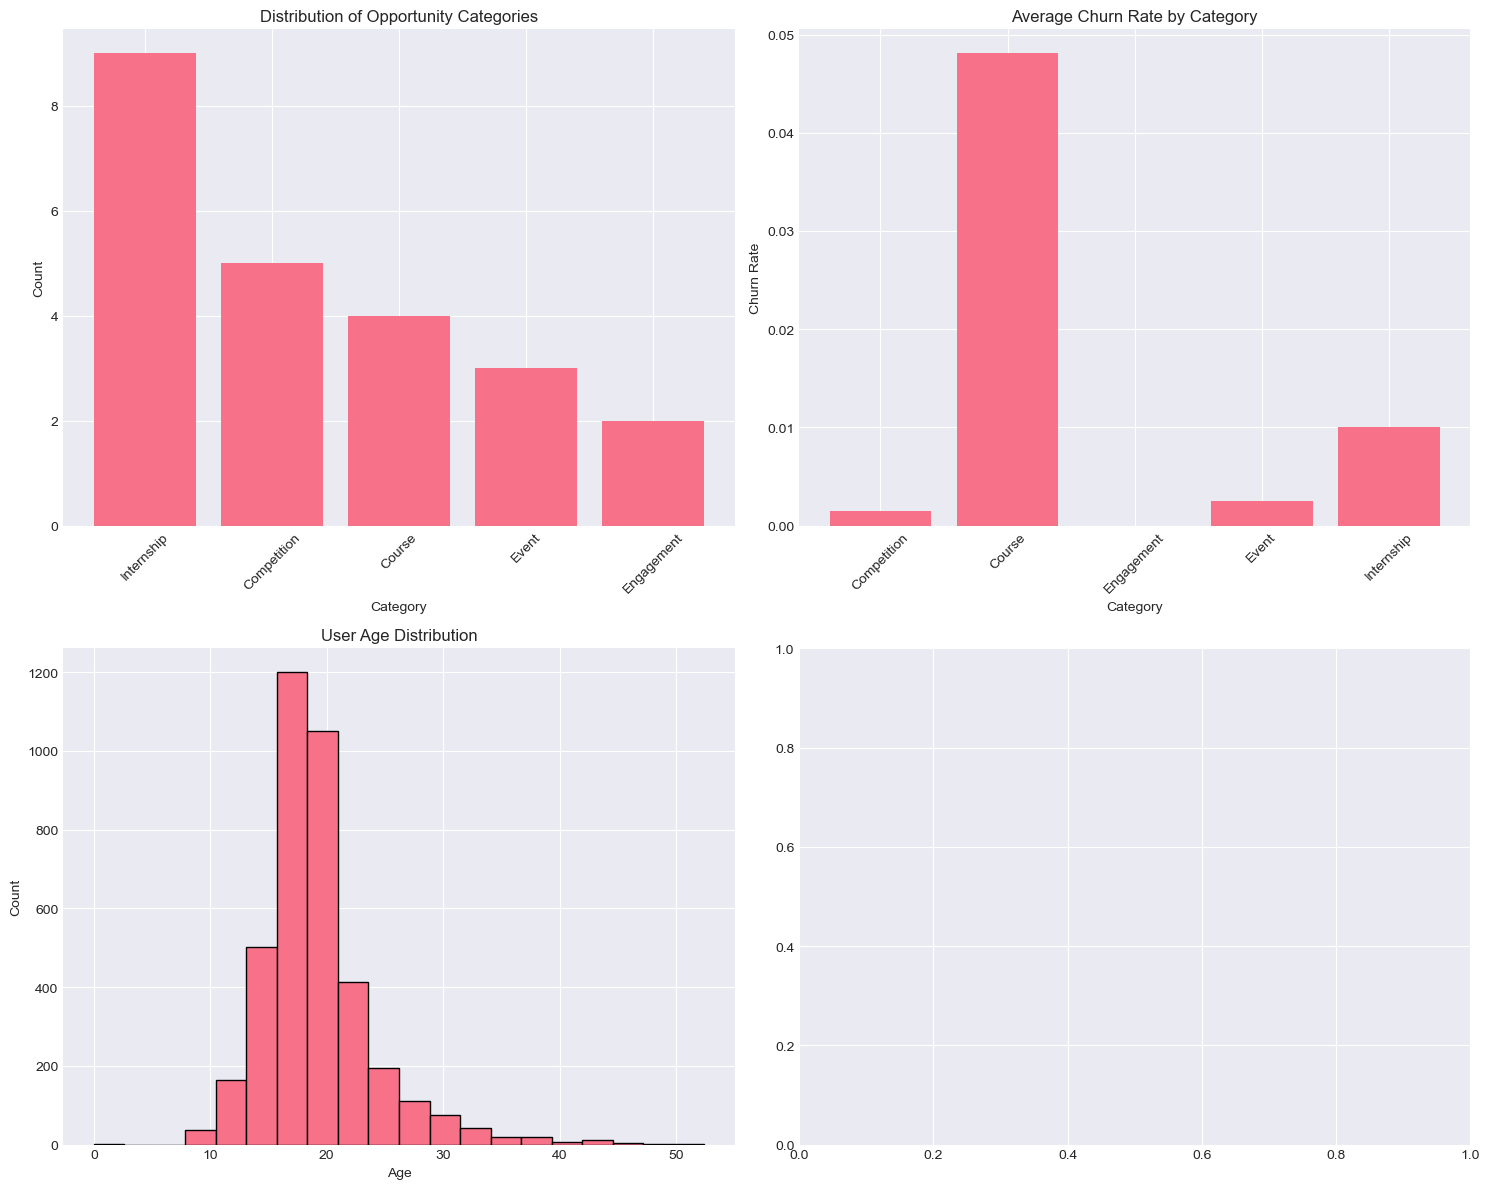

In [36]:
# 6. VISUALIZATION OF RECOMMENDATIONS
print("\n" + "-"*50)
print("VISUALIZING RECOMMENDATION RESULTS")
print("-"*50)

def visualize_recommendations(recommender):
    """
    Create visualizations for the recommendation system
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Opportunity categories distribution
    category_dist = opportunity_features['Opportunity_Category'].value_counts()
    axes[0, 0].bar(category_dist.index, category_dist.values)
    axes[0, 0].set_title('Distribution of Opportunity Categories')
    axes[0, 0].set_xlabel('Category')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Churn rate by category
    churn_by_category = opportunity_features.groupby('Opportunity_Category')['Opportunity_Churn_Rate'].mean()
    axes[0, 1].bar(churn_by_category.index, churn_by_category.values)
    axes[0, 1].set_title('Average Churn Rate by Category')
    axes[0, 1].set_xlabel('Category')
    axes[0, 1].set_ylabel('Churn Rate')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. User age distribution
    if 'Age' in user_features.columns:
        axes[1, 0].hist(user_features['Age'].dropna(), bins=20, edgecolor='black')
        axes[1, 0].set_title('User Age Distribution')
        axes[1, 0].set_xlabel('Age')
        axes[1, 0].set_ylabel('Count')
    
    # 4. Success probability vs popularity
    if not popular.empty and 'Success_Probability' in popular.columns:
        axes[1, 1].scatter(popular['Applicant_Count'], popular['Success_Probability'], alpha=0.6)
        axes[1, 1].set_title('Success Probability vs Popularity')
        axes[1, 1].set_xlabel('Number of Applicants')
        axes[1, 1].set_ylabel('Success Probability')
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
try:
    visualize_recommendations(recommender)
except Exception as e:
    print(f"Visualization error: {e}")
    print("Skipping visualizations...")

In [38]:
# 7. SAVE THE RECOMMENDATION SYSTEM
print("\n" + "-"*50)
print("SAVING RECOMMENDATION SYSTEM")
print("-"*50)

import pickle
import json

# Save recommendation artifacts
recommendation_artifacts = {
    'user_features': user_features,
    'opportunity_features': opportunity_features,
    'df': df[['User_ID', 'Opportunity_Id', 'Opportunity_Name', 'Opportunity_Category', 
              'Status_Description', 'Churn', 'Engagement_Score']].copy(),
    'model_info': {
        'total_users': len(user_features),
        'total_opportunities': len(opportunity_features),
        'created_at': str(datetime.now())
    }
}

# Save to files
with open('slu_recommendation_system.pkl', 'wb') as f:
    pickle.dump(recommender, f)

with open('recommendation_artifacts.json', 'w') as f:
    # Convert DataFrames to dict for JSON serialization
    artifacts_dict = {
        'user_features': user_features.head(100).to_dict('records'),  # Save first 100 users
        'opportunity_features': opportunity_features.to_dict('records'),
        'model_info': recommendation_artifacts['model_info']
    }
    json.dump(artifacts_dict, f, indent=2)

print("✓ Recommendation system saved to 'slu_recommendation_system.pkl'")
print("✓ Artifacts saved to 'recommendation_artifacts.json'")


--------------------------------------------------
SAVING RECOMMENDATION SYSTEM
--------------------------------------------------
✓ Recommendation system saved to 'slu_recommendation_system.pkl'
✓ Artifacts saved to 'recommendation_artifacts.json'


In [40]:
# 8. SUMMARY STATISTICS
print("\n" + "="*50)
print("RECOMMENDATION SYSTEM SUMMARY")
print("="*50)

print(f"\n📊 SYSTEM STATISTICS:")
print(f"   • Total Users: {len(user_features)}")
print(f"   • Total Opportunities: {len(opportunity_features)}")
print(f"   • Average Applications per User: {user_features['Total_Applications'].mean():.2f}")
print(f"   • Average Churn Rate: {df['Churn'].mean():.2%}")
print(f"   • Most Popular Category: {opportunity_features['Opportunity_Category'].mode()[0]}")
print(f"   • Lowest Churn Category: {opportunity_features.groupby('Opportunity_Category')['Opportunity_Churn_Rate'].mean().idxmin()}")

print(f"\n🎯 RECOMMENDATION TYPES AVAILABLE:")
print(f"   1. Content-Based Filtering (based on user profile)")
print(f"   2. Popularity-Based (for new users)")
print(f"   3. Similarity-Based (find similar opportunities)")
print(f"   4. Personalized Hybrid Recommendations")

print(f"\n🚀 EXAMPLE USAGE:")
print(f"   # Initialize system")
print(f"   recommender = SLURecommendationSystem(df, user_features, opportunity_features)")
print(f"   ")
print(f"   # Get personalized recommendations")
print(f"   recs = recommender.get_user_recommendations('user_id', top_n=10)")
print(f"   ")
print(f"   # Get popular recommendations")
print(f"   popular = recommender.get_popular_recommendations(top_n=10)")
print(f"   ")
print(f"   # Get similar opportunities")
print(f"   similar = recommender.get_similar_opportunities('opportunity_id', top_n=5)")

print("\n" + "="*50)
print("✅ RECOMMENDATION SYSTEM READY FOR DEPLOYMENT")
print("="*50)


RECOMMENDATION SYSTEM SUMMARY

📊 SYSTEM STATISTICS:
   • Total Users: 3850
   • Total Opportunities: 23
   • Average Applications per User: 2.22
   • Average Churn Rate: 2.28%
   • Most Popular Category: Internship
   • Lowest Churn Category: Engagement

🎯 RECOMMENDATION TYPES AVAILABLE:
   1. Content-Based Filtering (based on user profile)
   2. Popularity-Based (for new users)
   3. Similarity-Based (find similar opportunities)
   4. Personalized Hybrid Recommendations

🚀 EXAMPLE USAGE:
   # Initialize system
   recommender = SLURecommendationSystem(df, user_features, opportunity_features)
   
   # Get personalized recommendations
   recs = recommender.get_user_recommendations('user_id', top_n=10)
   
   # Get popular recommendations
   popular = recommender.get_popular_recommendations(top_n=10)
   
   # Get similar opportunities
   similar = recommender.get_similar_opportunities('opportunity_id', top_n=5)

✅ RECOMMENDATION SYSTEM READY FOR DEPLOYMENT


In [44]:
# 1. Initialize the system
recommender = SLURecommendationSystem(df, user_features, opportunity_features)

# 2. Get personalized recommendations for a user
user_recs = recommender.get_user_recommendations('User_ID', top_n=10)

# 3. Get popular recommendations (for new users)
popular_recs = recommender.get_popular_recommendations(top_n=10)

# 4. Find similar opportunities
similar_recs = recommender.get_similar_opportunities('Opportunity_ID', top_n=5)

# 5. Get user profile
profile = recommender.get_user_profile('User_ID')


Generating recommendations for user: User_ID
User not found. Returning popular recommendations.
Opportunity Opportunity_ID not found!
